## Imports

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

from os import listdir
from os.path import isfile, join

## Some initial config

In [87]:
INPUT_DIMS = [32,32]
BIN_DTYPE = 'int16'
PATH = "../Images/bin/"
CHECKPOINT_PATH = './best_weights'
SAMPLE = None
TEST_SIZE = 0.15
VALIDATION_SIZE = 0.10/(1-TEST_SIZE)

## Generate label DataFrame

In [88]:
liver_images = np.array([f for f in listdir(PATH) if isfile(join(PATH, f))])
#print(f"Number of liver image files: {len(liver_images)}")
cancer_types = np.array([f.split('_')[0] for f in liver_images])
patient_numbers = np.array([int(f.split('_')[1]) for f in liver_images])
slice_numbers = np.array([int(f.split('_')[2].split('.')[0]) for f in liver_images])

ldata = {'filename' : liver_images, 
         'cancer_type' : cancer_types, 
         'patient_id' : patient_numbers, 
         'slice_number' : slice_numbers}

image_labels = pd.DataFrame(data=ldata).sort_values(['cancer_type','patient_id','slice_number'],
                                                   ignore_index=True)
if SAMPLE:
    image_labels = image_labels.sample(SAMPLE)
image_labels.head()

,filename,cancer_type,patient_id,slice_number
0,HCC_1_1.bin,HCC,1,1
1,HCC_1_2.bin,HCC,1,2
2,HCC_1_3.bin,HCC,1,3
3,HCC_1_4.bin,HCC,1,4
4,HCC_1_5.bin,HCC,1,5


### Display some sample images

In [89]:
def get_image(fpath,d_type=BIN_DTYPE,dims=INPUT_DIMS):
    '''
    Returns a numpy array given a .bin file path and
    image dimensionality. Assumes input bin files are square
    
    Parameters
        fpath: file path to .bin file
        d_type: data type of .bin file
        dims: image dimensionality
    Returns
        image: numpy array from bin file data
    '''
    im_data = np.fromfile(fpath,d_type)
    n = int(np.sqrt(len(im_data)))
    image = np.reshape(np.fromfile(fpath,d_type),[n,n])
    scaled_image = cv2.resize(image,dims)
    return scaled_image

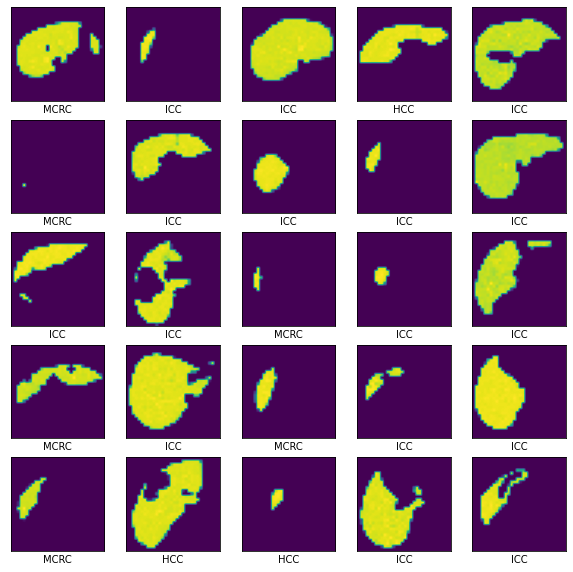

In [90]:
sample_labels = image_labels.sample(25)


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    img = get_image(PATH+sample_labels.filename.iloc[i])
    ctype = sample_labels.cancer_type.iloc[i]
    plt.imshow(img)
    plt.xlabel(ctype)
plt.show()

## Split Data into training and testing sets

In [91]:
#split df into cancer types
HCC_labels = image_labels.loc[image_labels.cancer_type == 'HCC']
ICC_labels = image_labels.loc[image_labels.cancer_type == 'ICC']
MCRC_labels = image_labels.loc[image_labels.cancer_type == 'MCRC']
print(f"{len(HCC_labels)} HCC images found")
print(f"{len(ICC_labels)} ICC images found")
print(f"{len(MCRC_labels)} MCRC images found")

5974 HCC images found
13140 ICC images found
9482 MCRC images found


In [92]:
from sklearn.model_selection import train_test_split

def split_patients(pat_ids,tsize=TEST_SIZE):
    train, test = train_test_split(pat_ids, test_size=tsize)
    return train, test

In [93]:
#for each cancer type, split into training, validation, and testing sets
hcc_all_train_ids, hcc_test_ids = split_patients(HCC_labels.patient_id.unique())
hcc_train_ids, hcc_valid_ids = split_patients(hcc_all_train_ids, VALIDATION_SIZE)

icc_all_train_ids, icc_test_ids = split_patients(ICC_labels.patient_id.unique())
icc_train_ids, icc_valid_ids = split_patients(icc_all_train_ids, VALIDATION_SIZE)

mcrc_all_train_ids, mcrc_test_ids = split_patients(MCRC_labels.patient_id.unique())
mcrc_train_ids, mcrc_valid_ids = split_patients(mcrc_all_train_ids, VALIDATION_SIZE)

#then generate label dataframes for each
HCC_train_labels = HCC_labels.loc[HCC_labels.patient_id.isin(hcc_train_ids)]
HCC_valid_labels = HCC_labels.loc[HCC_labels.patient_id.isin(hcc_valid_ids)]
HCC_test_labels = HCC_labels.loc[HCC_labels.patient_id.isin(hcc_test_ids)]

ICC_train_labels = ICC_labels.loc[ICC_labels.patient_id.isin(icc_train_ids)]
ICC_valid_labels = ICC_labels.loc[ICC_labels.patient_id.isin(icc_valid_ids)]
ICC_test_labels = ICC_labels.loc[ICC_labels.patient_id.isin(icc_test_ids)]

MCRC_train_labels = MCRC_labels.loc[MCRC_labels.patient_id.isin(mcrc_train_ids)]
MCRC_valid_labels = MCRC_labels.loc[MCRC_labels.patient_id.isin(mcrc_valid_ids)]
MCRC_test_labels = MCRC_labels.loc[MCRC_labels.patient_id.isin(mcrc_test_ids)]

In [94]:
train_rows=pd.concat([MCRC_train_labels,ICC_train_labels,HCC_train_labels],ignore_index=True).sample(frac=1)
valid_rows=pd.concat([MCRC_valid_labels,ICC_valid_labels,HCC_valid_labels],ignore_index=True).sample(frac=1)
test_rows=pd.concat([MCRC_test_labels,ICC_test_labels,HCC_test_labels],ignore_index=True).sample(frac=1)

total = len(train_rows) + len(valid_rows) + len(test_rows)
print(f"{total} total images split")
print(f"Train/validation/test ratio: {len(train_rows)/total:.2f}/{len(valid_rows)/total:.2f}/{len(test_rows)/total:.2f}")

28596 total images split
Train/validation/test ratio: 0.74/0.11/0.15


In [95]:
# dict to map cancer types to numerical classes
c_class = {'HCC':0,
          'ICC':1,
          'MCRC':2}

In [96]:
#preallocate training data array
n_train = len(train_rows)
train_images = np.zeros([n_train]+INPUT_DIMS,dtype=BIN_DTYPE)

for i in range(n_train):
    print(f"{i+1}/{n_train}", end='\r')
    train_images[i,:,:]=get_image(PATH+train_rows.filename.iloc[i])

train_labels = tf.one_hot(np.array([c_class[c] for c in train_rows.cancer_type.tolist()]),3)

In [97]:
#preallocate validation data array
n_valid = len(valid_rows)
valid_images = np.zeros([n_valid]+INPUT_DIMS,dtype=BIN_DTYPE)

for i in range(n_valid):
    print(f"{i+1}/{n_valid}", end='\r')
    valid_images[i,:,:]=get_image(PATH+valid_rows.filename.iloc[i])

valid_labels = tf.one_hot(np.array([c_class[c] for c in valid_rows.cancer_type.tolist()]),3)

In [98]:
#preallocate testing data array
n_test = len(test_rows)
test_images = np.zeros([n_test]+INPUT_DIMS,dtype=BIN_DTYPE)

for i in range(n_test):
    print(f"{i+1}/{n_test}", end='\r')
    test_images[i,:,:]=get_image(PATH+test_rows.filename.iloc[i])

test_labels = tf.one_hot(np.array([c_class[c] for c in test_rows.cancer_type.tolist()]),3)

In [99]:
#normalize images
train_images = (train_images + 1000)/4096
valid_images = (valid_images + 1000)/4096
test_images = (test_images + 1000)/4096

In [100]:
def remove_small(images, labels, thresh=0.01, dims=INPUT_DIMS):
    'removes small input images and labels with % of non-zero pixels below threshold'
    good = []
    n_pix = dims[0]*dims[1]
    for i in range(images.shape[0]):
        img = images[i]
        if np.sum(img > 0) / n_pix > thresh:
            good.append(i)
    images = images[good]
    labels = tf.convert_to_tensor(labels.numpy()[good])
    return images, labels

In [101]:
#remove images with low numbers of non-zero pixels
train_images, train_labels = remove_small(train_images, train_labels,0.01)
valid_images, valid_labels = remove_small(valid_images, valid_labels,0.01)
test_images, test_labels = remove_small(test_images, test_labels,0.01)

## Create Convolutional Base

In [163]:
#construct and compile the model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
np.random.seed(0)
from tensorflow.random import set_seed
set_seed(0)

K.clear_session()
inputShape = (train_images.shape[1],train_images.shape[2],1)

inp = Input(shape=inputShape)
conv1 = Conv2D(8,3)(inp)
act1 = Activation("relu")(conv1)
pool1 = MaxPooling2D((2,2))(act1)

conv2 = Conv2D(8,3)(pool1)
act2 = Activation("relu")(conv2)
pool2 = MaxPooling2D((2,2))(act2)

flat1 = Flatten()(pool2)
dense1 = Dense(256, activation='relu')(flat1)
dense2 = Dense(32, activation='relu')(dense1)
out = Dense(3, activation='softmax')(dense2)

model = Model(inp, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 8)         80        
                                                                 
 activation (Activation)     (None, 30, 30, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 8)         584       
                                                                 
 activation_1 (Activation)   (None, 13, 13, 8)         0         
                                                             

In [164]:
optimizer = Adam(learning_rate=6e-5)

#stop when validation loss starts to increase
es_callback = EarlyStopping(monitor='val_loss', patience=3)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics='accuracy')

history = model.fit(train_images,
                     train_labels,
                          epochs=100, batch_size=32, verbose=1,
                    validation_data=(valid_images,valid_labels),callbacks=[es_callback,cp_callback])

Epoch 1/100
638/640 [============================>.] - ETA: 0s - loss: 1.0520 - accuracy: 0.4535
Epoch 1: saving model to .\best_weights
640/640 [==============================] - 5s 7ms/step - loss: 1.0518 - accuracy: 0.4537 - val_loss: 1.0176 - val_accuracy: 0.4921
Epoch 2/100
637/640 [============================>.] - ETA: 0s - loss: 1.0237 - accuracy: 0.4640
Epoch 2: saving model to .\best_weights
640/640 [==============================] - 5s 7ms/step - loss: 1.0235 - accuracy: 0.4641 - val_loss: 0.9994 - val_accuracy: 0.5093
Epoch 3/100
637/640 [============================>.] - ETA: 0s - loss: 0.9976 - accuracy: 0.4877
Epoch 3: saving model to .\best_weights
640/640 [==============================] - 5s 8ms/step - loss: 0.9976 - accuracy: 0.4877 - val_loss: 0.9914 - val_accuracy: 0.5238
Epoch 4/100
638/640 [============================>.] - ETA: 0s - loss: 0.9813 - accuracy: 0.5002
Epoch 4: saving model to .\best_weights
640/640 [==============================] - 5s 8ms/step - lo

130/130 - 1s - loss: 1.0008 - accuracy: 0.5047 - 539ms/epoch - 4ms/step
0.5046976804733276


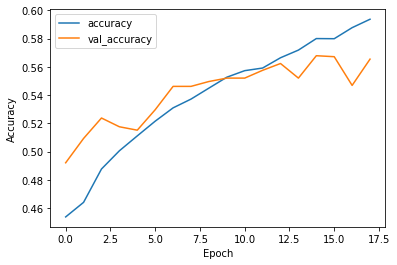

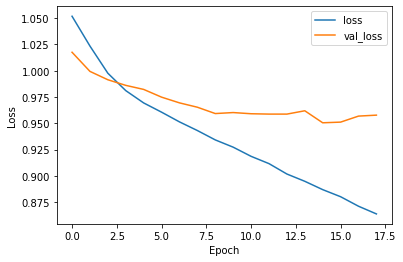

In [165]:
plt.figure(1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.35, 1])
plt.legend(loc='upper left')

plt.figure(2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0, 2])
plt.legend(loc='upper right')

#load best model weights from training
model.load_weights(CHECKPOINT_PATH)

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

## Results

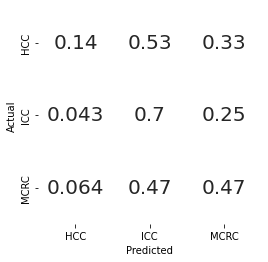

In [170]:
from sklearn import metrics
import seaborn as sns
from matplotlib.colors import ListedColormap

y_actual = test_labels.numpy().argmax(axis=1).astype(int)
y_preds = model.predict(test_images).argmax(axis=1)

confusion_matrix = metrics.confusion_matrix(y_actual, y_preds)
con_mat_norm = (confusion_matrix.T / confusion_matrix.sum(axis=1)).T

conf_figure = pd.DataFrame(con_mat_norm, index = ['HCC', 'ICC', 'MCRC'], columns = ['HCC', 'ICC', 'MCRC'])
conf_figure.index.name = 'Actual'
conf_figure.columns.name = 'Predicted'

plt.figure(figsize=(4,4))

sns.heatmap(conf_figure,
                cbar=False,
                square=False,
                annot=True,
                annot_kws={"size": 20},
                cmap=ListedColormap(['white']),
                linewidths=0.5)
plt.show()

In [249]:
from sklearn.metrics import classification_report

print(classification_report(y_actual,y_preds,target_names=['HCC','ICC','MCRC']))

              precision    recall  f1-score   support

         HCC       0.41      0.14      0.20       869
         ICC       0.54      0.70      0.61      1877
        MCRC       0.46      0.47      0.46      1405

    accuracy                           0.50      4151
   macro avg       0.47      0.44      0.43      4151
weighted avg       0.49      0.50      0.48      4151



In [212]:
#printing ROC curve for each class

from sklearn.metrics import roc_curve, auc
from itertools import cycle

n_classes = 3
c_class_rev = {0:'HCC',
          1:'ICC',
          2:'MCRC'}
fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2

oh_preds = tf.one_hot(y_preds,3).numpy()
oh_act = tf.one_hot(y_actual,3).numpy()

for i in range(n_classes):
    preds = oh_preds[:,i]
    act = oh_act[:,i]
    fpr[i], tpr[i], _ = roc_curve(act, preds)
    roc_auc[i] = auc(fpr[i], tpr[i])

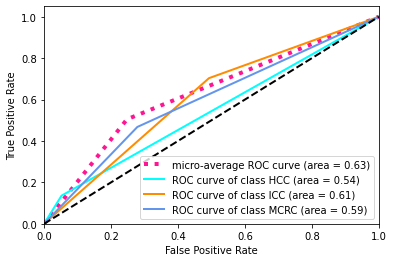

In [213]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(oh_act.ravel(), oh_preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label=f"ROC curve of class {c_class_rev[i]} (area = {roc_auc[i]:.2f})"
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()